In [1]:
import os
import time
import torch
import torchvision

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import cv2 as cv

from pathlib import Path
from PIL import Image
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import train_test_split

from src.data import blend
from src.models import PretrainedUNet
from src.metrics import jaccard, dice

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [87]:
data_folder = Path("data")
models_folder = Path("models")
data_description = pd.read_csv(data_folder / "train.csv")

In [4]:
splits = {}
splits["train"], splits["test"] = train_test_split(data_description, test_size=0.2, random_state=42)
splits["train"], splits["val"] = train_test_split(splits["train"], test_size=0.1, random_state=42)

splits["train"] = splits["train"].reset_index(drop=True)
splits["test"] = splits["test"].reset_index(drop=True)
splits["val"] = splits["val"].reset_index(drop=True)

In [101]:
class HumanSegmentDataset(torch.utils.data.Dataset):
    def __init__(self, description, data_folder, transfrom=None):
        self.description = description
        self.data_folder = data_folder
        self.transfrom = transfrom
        
        
    def __getitem__(self, idx):
        try:
            origin_fn = self.data_folder / self.description.loc[idx, "origin"]
            mask_fn = self.data_folder / self.description.loc[idx, "mask"]

            origin = Image.open(origin_fn)
            if origin.mode != "RGB":
                origin = origin.convert("RGB")

            mask = Image.open(mask_fn)

            if self.transfrom is not None:
                transformed = self.transfrom(
                    image=np.array(origin),
                    mask=np.array(mask)
                )
                origin = transformed["image"]
                mask = transformed["mask"]

            origin = torchvision.transforms.functional.to_tensor(origin) - 0.5
            mask = (torch.tensor(np.array(mask)) > 0).long() 

            return origin, mask
        except Exception as e:
            
            print(f"current idx: {idx}", e)
            return torch.zeros((3, 512, 512)), torch.zeros((512, 512)).long()
        
    def __len__(self):
        return len(self.description)

In [102]:
batch_size = 4

train_transforms = A.Compose([
#     A.Rotate()
    A.ShiftScaleRotate(scale_limit=0.02, rotate_limit=0, border_mode=0, value=0),
    A.Resize(512, 512),
    A.HorizontalFlip(),
#     A.RandomRotate90(),
])

test_val_transforms = A.Compose([
#     A.Rotate()
#     A.ShiftScaleRotate(scale_limit=0.02, rotate_limit=0, border_mode=0, value=0),
    A.Resize(512, 512),
#     A.HorizontalFlip(),
#     A.RandomRotate90(),
])


datasets = {mode: HumanSegmentDataset(
    splits[mode],
    data_folder,
    train_transforms if mode == "train" else test_val_transforms
) for mode in ["train", "test", "val"]}

dataloaders = {x: torch.utils.data.DataLoader(
    datasets[x], 
    batch_size=batch_size
) for x in ["train", "test", "val"]}

loading time: 0.01036214828491211


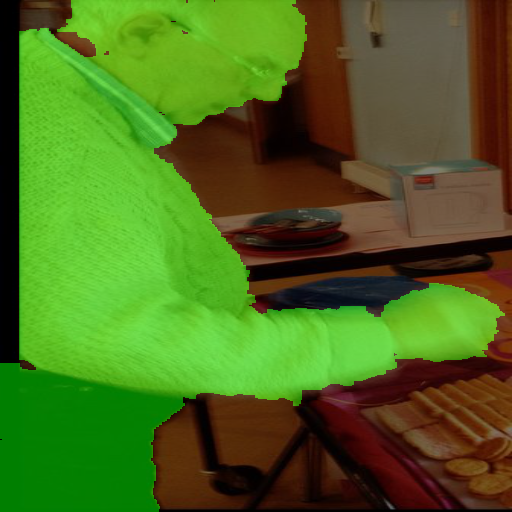

In [14]:
start_t = time.time()

image, mask = datasets["train"][67783]


end_t = time.time()
print(f"loading time: {end_t - start_t}")

blend(image+0.5, mask)

## Training 

In [15]:
unet = PretrainedUNet(
    in_channels=3,
    out_channels=2, 
    batch_norm=True, 
    upscale_mode="bilinear"
)

In [16]:
# pretrained_model_name = "unet-1v.pt"
# unet.load_state_dict(torch.load(
#     models_folder / pretrained_model_name,
#     map_location=torch.device("cpu")
# ))

unet.to(device)
unet.train();

optimizer = torch.optim.Adam(unet.parameters(), lr=0.0005)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [17]:
train_log_filename = "hs-train-log.txt"
epochs = 18
best_val_loss = np.inf
model_name = "hs-unet-v0.pt"

In [ ]:
hist = []

for e in range(epochs):
    start_t = time.time()
    
    unet.train()
    train_loss = 0.0
    pbar_desc = f"epoch: {e+1}/{epochs}, train phase"
    
    for origins, masks in tqdm(dataloaders["train"], desc=pbar_desc, position=0, leave=True):
#         scheduler.step()
        
        num = origins.size(0)
        
        origins = origins.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        
        outs = unet(origins)
        softmax = torch.nn.functional.log_softmax(outs, dim=1)
        loss = torch.nn.functional.nll_loss(softmax, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * num
        
    train_loss = train_loss / len(datasets['train'])
    
    
    unet.eval()
    val_loss = 0.0
    val_jaccard = 0.0
    val_dice = 0.0
    pbar_desc = f"epoch: {e+1}/{epochs}, validation phase"
        
    for origins, masks in tqdm(dataloaders["val"], desc=pbar_desc, position=0, leave=True):
        num = origins.size(0)

        origins = origins.to(device)
        masks = masks.to(device)

        with torch.no_grad():
            outs = unet(origins)
            softmax = torch.nn.functional.log_softmax(outs, dim=1)
            val_loss += torch.nn.functional.nll_loss(softmax, masks).item() * num

            outs = torch.argmax(softmax, dim=1)
            outs = outs.float()
            masks = masks.float()
            val_jaccard += jaccard(masks, outs.float()).item() * num
            val_dice += dice(masks, outs).item() * num

#         print(".", end="")
    val_loss = val_loss / len(datasets["val"])
    val_jaccard = val_jaccard / len(datasets["val"])
    val_dice = val_dice / len(datasets["val"])
    
    
    end_t = time.time()
    spended_t = end_t - start_t
    
    with open(train_log_filename, "a") as train_log_file:
        report = f"epoch: {e+1}/{epochs}, time: {spended_t}, train loss: {train_loss}, \n"\
               + f"val loss: {val_loss}, val jaccard: {val_jaccard}, val dice: {val_dice}"

        hist.append({
            "time": spended_t,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_jaccard": val_jaccard,
            "val_dice": val_dice,
        })

        print(report)
        train_log_file.write(report + "\n")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(unet.state_dict(), models_folder / model_name)
            print("model saved")
            train_log_file.write("model saved\n")
        print()
        

epoch: 1/18, train phase:  53%|█████▎    | 8957/16946 [1:06:17<1:02:11,  2.14it/s]

current idx: 35831 tuple index out of range


epoch: 1/18, train phase:  56%|█████▌    | 9433/16946 [1:10:03<1:01:31,  2.04it/s]

current idx: 37735 local variable 'photoshop' referenced before assignment


epoch: 1/18, train phase:  63%|██████▎   | 10709/16946 [1:20:11<50:47,  2.05it/s]  

current idx: 42838 tuple index out of range


epoch: 1/18, train phase:  99%|█████████▊| 16695/16946 [2:08:09<02:21,  1.77it/s]

current idx: 66782 tuple index out of range


epoch: 1/18, validation phase: 100%|██████████| 1883/1883 [08:01<00:00,  3.72it/s]

epoch: 1/18, time: 8298.177202701569, train loss: 0.24530973188754068, 
val loss: 0.24798378640161634, val jaccard: 0.7779899186361234, val dice: 0.8583288849571317


epoch: 2/18, train phase:   0%|          | 0/16946 [00:00<?, ?it/s]

model saved



epoch: 2/18, train phase:  48%|████▊     | 8163/16946 [1:08:42<1:12:09,  2.03it/s]

In [88]:
torch.save(unet.state_dict(), models_folder / model_name)

In [130]:
unet.train();

In [62]:
datasets["train"][8957 * 4 + 3][0].shape

data/LV-MHP-v2/train/images/24328.jpg
data/LV-MHP-v2/train/masks/24328.png
current idx: 35831 tuple index out of range


torch.Size([3, 512, 512])

epochs: 80, overall time: 791.0m, mean epoch time: 593.9059314757585s


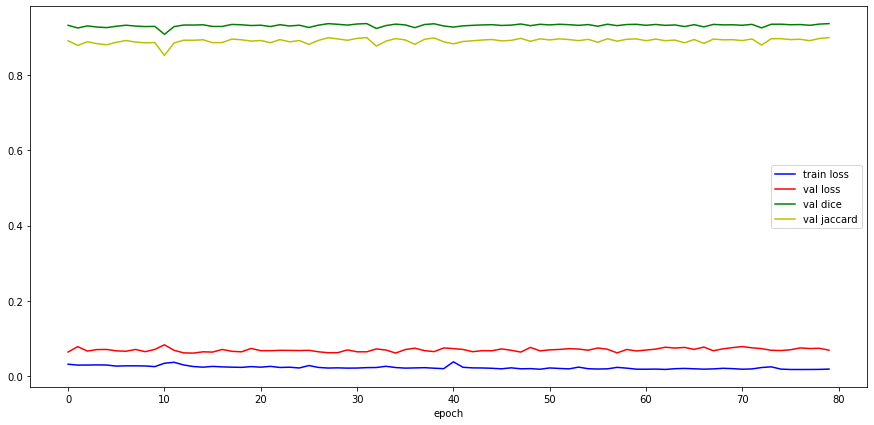

In [110]:
plt.figure(figsize=(15,7))
train_loss_hist = [h["train_loss"] for h in hist]
plt.plot(range(len(hist)), train_loss_hist, "b", label="train loss")

val_loss_hist = [h["val_loss"] for h in hist]
plt.plot(range(len(hist)), val_loss_hist, "r", label="val loss")

val_dice_hist = [h["val_dice"] for h in hist]
plt.plot(range(len(hist)), val_dice_hist, "g", label="val dice")

val_jaccard_hist = [h["val_jaccard"] for h in hist]
plt.plot(range(len(hist)), val_jaccard_hist, "y", label="val jaccard")

plt.legend()
plt.xlabel("epoch")
plt.savefig(images_folder / model_name.replace(".pt", "-train-hist.png"))

time_hist = [h["time"] for h in hist]
overall_time = sum(time_hist) // 60
mean_epoch_time = sum(time_hist) / len(hist)
print(f"epochs: {len(hist)}, overall time: {overall_time}m, mean epoch time: {mean_epoch_time}s")

## Evaluation

In [111]:
unet = PretrainedUNet(
    in_channels=3,
    out_channels=2, 
    batch_norm=True, 
    upscale_mode="bilinear"
)

In [108]:
# model_name = "ssa-unet-1v.pt"
# unet.load_state_dict(torch.load(models_folder / model_name, map_location=torch.device("cpu")))
# unet.to(device)
unet.eval();

In [105]:
test_loss = 0.0
test_jaccard = 0.0
test_dice = 0.0

for origins, masks in tqdm(dataloaders["test"], position=0, leave=True):
    num = origins.size(0)

    origins = origins.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        outs = unet(origins)
        softmax = torch.nn.functional.log_softmax(outs, dim=1)
        test_loss += torch.nn.functional.nll_loss(softmax, masks).item() * num

        outs = torch.argmax(softmax, dim=1)
        outs = outs.float()
        masks = masks.float()
        test_jaccard += jaccard(masks, outs).item() * num
        test_dice += dice(masks, outs).item() * num

test_loss = test_loss / len(datasets["test"])
test_jaccard = test_jaccard / len(datasets["test"])
test_dice = test_dice / len(datasets["test"])

print(f"avg test loss: {test_loss}")
print(f"avg test jaccard: {test_jaccard}")
print(f"avg test dice: {test_dice}")

## Inference


In [59]:
unet = PretrainedUNet(
    in_channels=3,
    out_channels=2, 
    batch_norm=True, 
    upscale_mode="bilinear"
)

In [60]:
model_name = "hs-unet-v0.pt"
unet.load_state_dict(torch.load(models_folder / model_name, map_location=torch.device("cpu")))
unet.to(device)
unet.eval();

In [61]:
device

device(type='cuda', index=0)

In [127]:
origin, mask = datasets["test"][6]

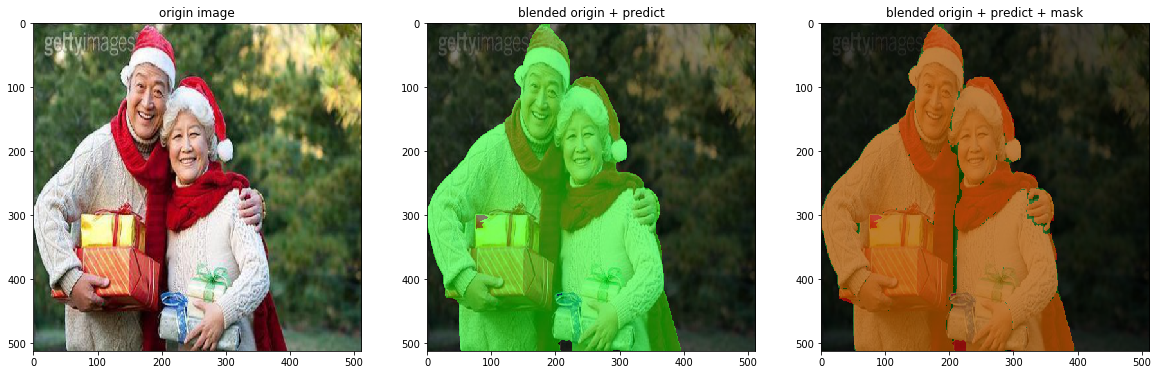

In [128]:
with torch.no_grad():
    origin = torch.stack([origin])
    origin = origin.to(device)
    out = unet(origin)
    softmax = torch.nn.functional.log_softmax(out, dim=1)
    out = torch.argmax(softmax, dim=1)
    
    origin = origin[0].to("cpu")
    out = out[0].to("cpu")

plt.figure(figsize=(20, 10))
pil_origin = torchvision.transforms.functional.to_pil_image(origin + 0.5).convert("RGB")

plt.subplot(1, 3, 1)
plt.title("origin image")
plt.imshow(np.array(pil_origin))

plt.subplot(1, 3, 2)
plt.title("blended origin + predict")
plt.imshow(np.array(blend(origin + 0.5, out)));
# plt.savefig(images_folder / "ssa-building-segmantation-4.png")

plt.subplot(1, 3, 3)
plt.title("blended origin + predict + mask")
plt.imshow(np.array(blend(origin + 0.5, out, mask)));


# plt.savefig(images_folder / "ssa-building-segmantation-3.png")